In [4]:
%pip install pandas scikit-learn numpy==1.26.4 catboost matplotlib seaborn memory_profiler setuptools

Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext memory_profiler

In [2]:
import numpy as np
from sklearn.model_selection import GridSearchCV
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.errors import SettingWithCopyWarning
from catboost import CatBoostClassifier
import warnings
import matplotlib.pyplot as plt
warnings.simplefilter('ignore', SettingWithCopyWarning)

In [3]:
cols = [ 'Day of the week_sin', 'Day of the week_cos', 'Day of the week', 'CarCount', 'BikeCount', 'BusCount', 'Traffic Situation', 'Minute_sin', 'Minute_cos', 'Hour_sin', 'Hour_cos', 'IsDay' ]
data = pd.read_csv('./data/raw.csv', index_col=0)[cols]
data.head()

features = data.drop(columns=['Traffic Situation'])
target = data['Traffic Situation']

train_size = int(0.8 * len(data))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

In [4]:
cols=['CarCount', 'BikeCount', 'BusCount']
scaler = StandardScaler()

scaler.fit(X_train[cols])
X_train[cols] = scaler.transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])



In [4]:
import pickle

with open('./model/std-scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [5]:
lags = 4
lag_cols=['CarCount', 'BikeCount', 'BusCount']
for col in lag_cols:
    for lag in range(1, lags+1):
        X_train[f'{col}_lag{lag}'] = X_train[col].shift(lag)
        X_test[f'{col}_lag{lag}'] = X_test[col].shift(lag)

X_train = X_train.iloc[4:]
y_train = y_train.iloc[4:]
X_test = X_test.iloc[4:]
y_test = y_test.iloc[4:]


In [ ]:
param_grid = {
    'depth': [4, 5, 6],            
    'learning_rate': [0.03, 0.05, 0.07, 0.1],   
    'l2_leaf_reg': [1, 3, 5, 7, 10]      
}

model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    iterations=750,
    logging_level='Silent',
    cat_features=["Day of the week", "IsDay"],
    auto_class_weights='Balanced'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy' # Можно f1, precision, recall, totalf1
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

In [ ]:
#%%timeit
#%%memit

model = CatBoostClassifier(
    iterations=750,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=1,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    logging_level='Silent',
    auto_class_weights='Balanced',
    cat_features=["IsDay", 'Day of the week']
)

_ = model.fit(X_train, y_train)

peak memory: 450.41 MiB, increment: 8.62 MiB


In [7]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.58      0.55       190
           1       0.85      0.78      0.81       638
           2       0.53      0.71      0.61        79
           3       0.95      0.96      0.95       280

    accuracy                           0.78      1187
   macro avg       0.71      0.76      0.73      1187
weighted avg       0.80      0.78      0.79      1187

Confusion Matrix:
[[111  72   7   0]
 [ 98 496  32  12]
 [  4  16  56   3]
 [  0   2  10 268]]


                Feature  Importance
7            Minute_cos    1.112891
6            Minute_sin    1.553521
20        BusCount_lag2    1.840484
10                IsDay    1.922871
21        BusCount_lag3    1.933768
22        BusCount_lag4    1.943381
1   Day of the week_cos    1.951735
0   Day of the week_sin    2.506040
17       BikeCount_lag3    2.563493
19        BusCount_lag1    2.675435
16       BikeCount_lag2    2.783985
18       BikeCount_lag4    2.785365
14        CarCount_lag4    2.794883
12        CarCount_lag2    2.813144
15       BikeCount_lag1    3.069748
13        CarCount_lag3    3.154264
2       Day of the week    3.384202
11        CarCount_lag1    3.515089
8              Hour_sin    4.769649
9              Hour_cos    5.071211
4             BikeCount    6.954586
5              BusCount   14.650324
3              CarCount   24.249932


/tmp/ipykernel_10088/2956505416.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


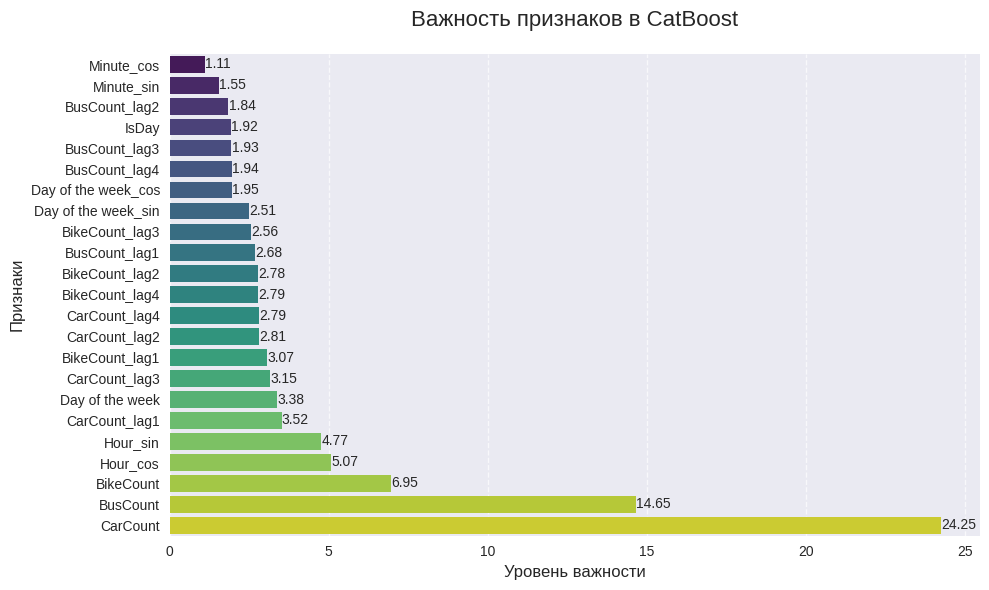

In [26]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=True)

print(importance_df)
plt.style.use('seaborn-v0_8')  # Или другой доступный стиль из plt.style.available

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='Importance', 
    y='Feature', 
    data=importance_df,
    palette='viridis'
)

for i, (value, name) in enumerate(zip(importance_df['Importance'], importance_df['Feature'])):
    ax.text(value + 0.01, i, f'{value:.2f}', ha='left', va='center')

plt.title('Важность признаков в CatBoost', fontsize=16, pad=20)
plt.xlabel('Уровень важности', fontsize=12)
plt.ylabel('Признаки', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
sns.despine()

plt.tight_layout()
plt.show()

In [7]:
selected_features = [ 'CarCount', 'BikeCount', 'BusCount', 'CarCount_lag1', 'BikeCount_lag1', 'BusCount_lag1', 'Day of the week', 'Hour_sin', 'Hour_cos']

X_selected_train = X_train[selected_features]
X_selected_test = X_test[selected_features]

In [ ]:
#%%timeit
#%%memit

model = CatBoostClassifier(
    iterations=750,
    learning_rate=0.1,
    depth=6,
    l2_leaf_reg=1,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    random_seed=42,
    logging_level='Silent',
    auto_class_weights='Balanced'
)

model.fit(X_selected_train, y_train)

895 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
#%%timeit
#%%memit

y_pred = model.predict(X_selected_test)

240 μs ± 1.76 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.63      0.57       190
           1       0.86      0.77      0.81       638
           2       0.57      0.68      0.62        79
           3       0.93      0.97      0.95       280

    accuracy                           0.79      1187
   macro avg       0.72      0.76      0.74      1187
weighted avg       0.80      0.79      0.79      1187

Confusion Matrix:
[[120  62   8   0]
 [104 493  25  16]
 [  5  16  54   4]
 [  0   2   7 271]]


In [13]:
model.save_model('./model/catboost.cbm')